# **Exploratory Data Analysis (EDA)**

In [31]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import SimpleITK as sitk
import os

# Paths
PROJECT_ROOT = Path(os.getcwd()).parent if 'notebooks' in os.getcwd() else Path(os.getcwd())
DATA_DIR = PROJECT_ROOT / "dataset"
IMAGE_DIR = DATA_DIR / "images"
METADATA_PATH = DATA_DIR / "metadata.csv"

# Estilos
sns.set_theme(style="whitegrid")

print(f"Project Root: {PROJECT_ROOT}")
print(f"Image Dir: {IMAGE_DIR}")
print(f"Metadata: {METADATA_PATH}")
print(f"Existe metadata: {METADATA_PATH.exists()}")
print(f"Existe images dir: {IMAGE_DIR.exists()}")

Project Root: c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo
Image Dir: c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\dataset\images
Metadata: c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\dataset\metadata.csv
Existe metadata: True
Existe images dir: True


In [32]:
# Metadata
meta = pd.read_csv(METADATA_PATH)
print(meta.shape)
meta.head()

(5224, 7)


,Unnamed: 0,height,img_name,label,width,x,y
0,0,94,n0239.mha,1,92,776,579
1,1,40,n0342.mha,1,27,223,642
2,2,111,n0996.mha,1,159,687,310
3,3,84,n0418.mha,1,81,343,510
4,4,69,n0538.mha,1,62,599,645


Podemos observar que el **Metadata** cuenta con 5224 filas. Cada fila puede representar una Imagen Negativa (sin Nódulo) o una anotación de un Nódulo específico en una Imagen Positiva. Esto significa que una misma imagen puede aparecer varias veces si tiene múltiples nódulos.

El **Dataset** tiene 7 Columnas que dan Información de cada Anotación: el nombre de la imagen, la clase (0 o 1), y las coordenadas de las bounding boxes (x, y, ancho, alto) que están en 0 para Imágenes Negativas.

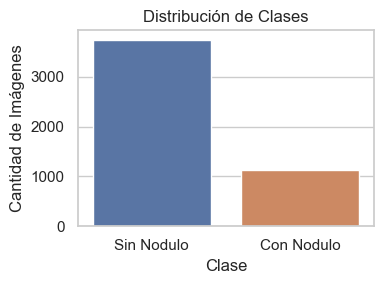

Total de Imágenes Únicas: 4882
Negativos: 3748 (76.8%) | Positivos: 1134 (23.2%)

Total de Anotaciones en Metadata: 5224 (incluye múltiples nódulos por imagen)


In [33]:
# Distribución de clases (imágenes únicas)
unique_images = meta.groupby('img_name')['label'].max().reset_index()
label_counts = unique_images['label'].value_counts().sort_index()
class_map = {0: 'Sin Nodulo', 1: 'Con Nodulo'}
label_counts.index = label_counts.index.map(class_map)

plt.figure(figsize=(4,3))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette=['#4c72b0', '#dd8452'], legend=False)
plt.title('Distribución de Clases')
plt.ylabel('Cantidad de Imágenes')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

pos_pct = 100 * label_counts['Con Nodulo'] / label_counts.sum()
neg_pct = 100 * label_counts['Sin Nodulo'] / label_counts.sum()
total_imgs = label_counts.sum()
print(f"Total de Imágenes Únicas: {total_imgs}")
print(f"Negativos: {label_counts['Sin Nodulo']} ({neg_pct:.1f}%) | Positivos: {label_counts['Con Nodulo']} ({pos_pct:.1f}%)")
print(f"\nTotal de Anotaciones en Metadata: {len(meta)} (incluye múltiples nódulos por imagen)")

Con estos Datos podemos ver que, a nivel de Imágenes Únicas, la Clase Negativa predomina con una relación aproximada de 2.5 a 1 sobre la Positiva.

Debido a este Desbalance, el modelo podría sesgarse hacia los "Negativos". Para contrarrestar esto no usaremos la Accuracy como métrica principal, ya que un modelo que siempre prediga "Negativo" tendría aproximadamente un 71-72% de acierto sin haber aprendido nada útil. 

Para manejar este Desbalance utilizaremos asignación de Pesos durante el Entrenamiento y priorizaremos métricas más informativas como el área bajo la curva ROC (AUC) y el F1-Score para evaluar el rendimiento real de los modelos.

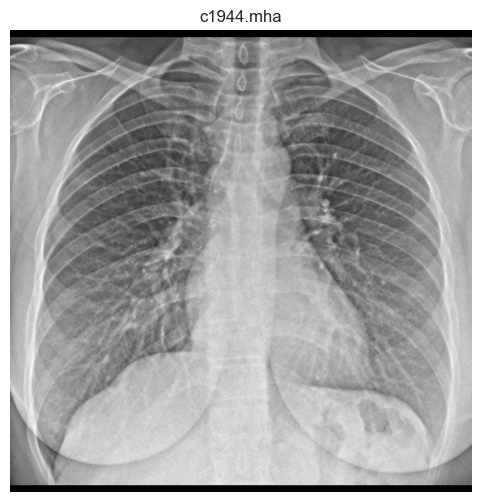

In [ ]:
# Carga imagen
def load_mha(path: Path):
    img = sitk.ReadImage(str(path))
    arr = sitk.GetArrayFromImage(img)
    if arr.ndim == 3:
        arr = arr.squeeze()
    return arr, img

# Mostrar imagen con cajas
def plot_image_with_boxes(img_np, boxes=None, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img_np, cmap='gray')
    if boxes is not None and len(boxes) > 0:
        for (_, row) in boxes.iterrows():
            x, y, w, h = row[['x','y','width','height']]
            rect = plt.Rectangle((x, y), w, h, fill=False, color='lime', linewidth=1.5)
            plt.gca().add_patch(rect)
    plt.title(title or '')
    plt.axis('off')
    plt.show()

# Cargamos la imagen aleatoria y le pintamos las cajas (en caso de que tenga)
sample_row = meta.sample(1).iloc[0]
img_name = sample_row['img_name']
sample_img = IMAGE_DIR / img_name
img_np, img_obj = load_mha(sample_img)
plot_image_with_boxes(img_np, title=img_name)

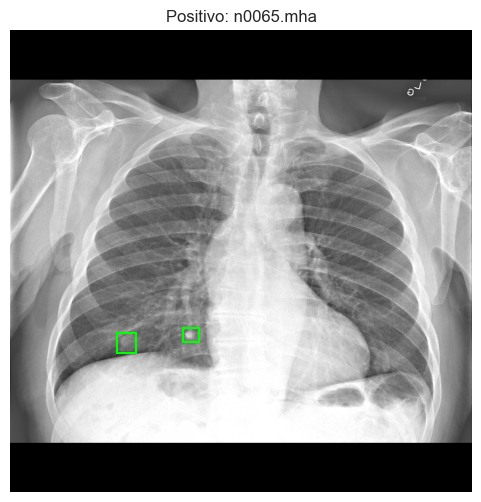

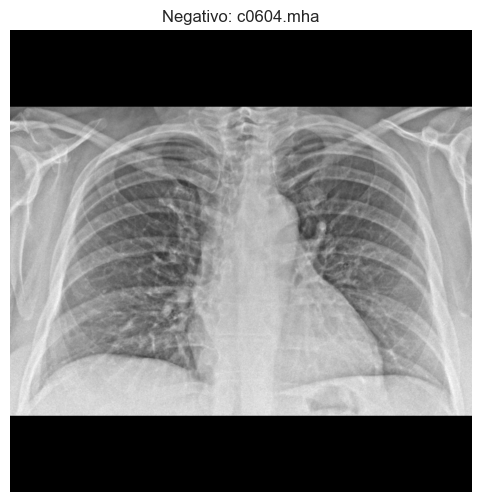

In [ ]:
# Elegimos un ejemplo Positivo y otro Negativo
pos_row = meta[meta['label'] == 1].sample(1).iloc[0]
neg_row = meta[meta['label'] == 0].sample(1).iloc[0]

# Positivo
pos_img_path = IMAGE_DIR / pos_row['img_name']
pos_img_np, _ = load_mha(pos_img_path)
pos_boxes = meta[meta['img_name'] == pos_row['img_name']]
plot_image_with_boxes(pos_img_np, pos_boxes, title=f"Positivo: {pos_row['img_name']}")

# Negativo
neg_img_path = IMAGE_DIR / neg_row['img_name']
neg_img_np, _ = load_mha(neg_img_path)
plot_image_with_boxes(neg_img_np, None, title=f"Negativo: {neg_row['img_name']}")

Distribución de nódulos por imagen (solo imágenes positivas):
  1 nódulo(s): 893 imágenes (78.7%)
  2 nódulo(s): 140 imágenes (12.3%)
  3 nódulo(s): 101 imágenes (8.9%)


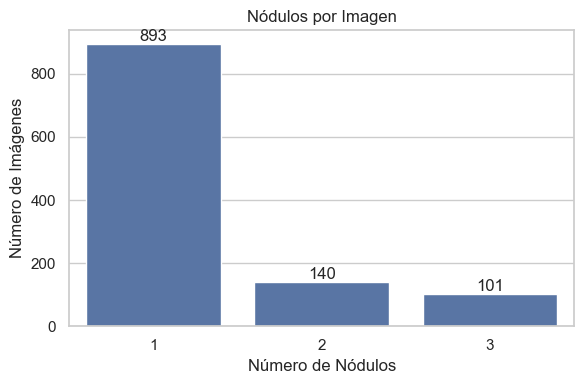


 Estadísticas de bounding boxes (1476 nódulos anotados):
             width       height
count  1476.000000  1476.000000
mean     57.371951    59.482385
std      23.146619    24.105510
min       1.000000    12.000000
25%      41.000000    42.750000
50%      52.000000    54.000000
75%      69.000000    72.000000
max     159.000000   187.000000


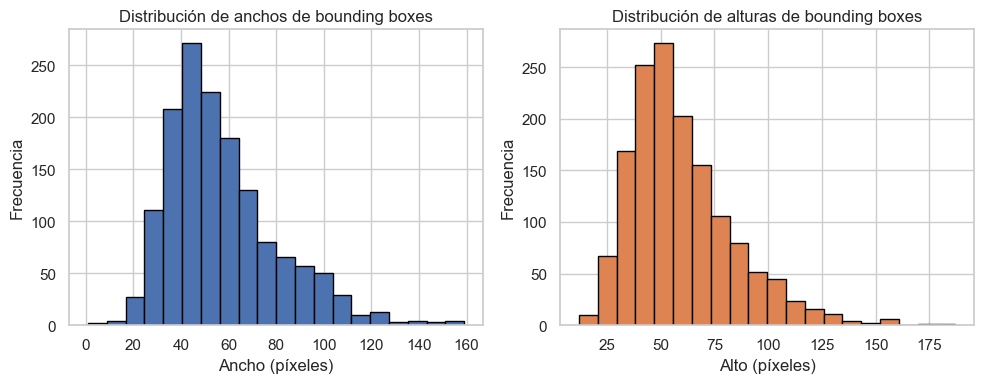

In [38]:
# Análisis de imágenes con Múltiples Nódulos
unique_pos_imgs = meta[meta['label'] == 1].groupby('img_name').size()

print("Distribución de nódulos por imagen (solo imágenes positivas):")
nodule_distribution = unique_pos_imgs.value_counts().sort_index()
for n_nodules, count in nodule_distribution.items():
    pct = 100 * count / len(unique_pos_imgs)
    print(f"  {int(n_nodules)} nódulo(s): {count} imágenes ({pct:.1f}%)")

# Gráfico
plt.figure(figsize=(6,4))
ax = sns.countplot(x=unique_pos_imgs.values, color='#4c72b0')
plt.title('Nódulos por Imagen')
plt.xlabel('Número de Nódulos')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=0)

# Valores encima de las barras
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

# Dimensiones de las bounding boxes (excluyendo width=0 y height=0)
bboxes_reales = meta[(meta['width'] > 0) & (meta['height'] > 0)]
print(f"\n Estadísticas de las Bounding Boxes ({len(bboxes_reales)} nódulos anotados):")
print(bboxes_reales[['width','height']].describe())

# Distribución de tamaños
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(bboxes_reales['width'], bins=20, color='#4c72b0', edgecolor='black')
axes[0].set_title('Distribución de anchos de bounding boxes')
axes[0].set_xlabel('Ancho (píxeles)')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(bboxes_reales['height'], bins=20, color='#dd8452', edgecolor='black')
axes[1].set_title('Distribución de alturas de bounding boxes')
axes[1].set_xlabel('Alto (píxeles)')
axes[1].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

Del análisis de múltiples nódulos podemos ver que la gran mayoría de las imágenes positivas (78.7%) contienen 1 solo nódulo. Sin embargo, hay un porcentaje considerable con múltiples nódulos: 12.3% tienen 2 nódulos y 8.9% tienen 3 nódulos. Es importante tenerlo en cuenta porque, durante el entrenamiento, necesitaremos considerar todas las anotaciones de cada imagen.

En cuanto a las dimensiones de los nódulos, tenemos un total de 1476 nódulos anotados, que tienen un tamaño promedio de aproximadamente 57x59 píxeles. Aún así, podemos observar que hay bastante variabilidad, ya que hay una desviación estándar de entre 23-24 píxeles. 

Los tamaños van desde nódulos muy pequeños (1x12 píxeles) hasta bastante grandes (159x187 píxeles). El 50% de los nódulos están entre 41-69 píxeles de ancho y 42-72 píxeles de alto, lo que nos da una idea del rango típico que debemos esperar.